# Experiment F: Per-Tier Binary Classifiers
## LinkedIn Engagement Prediction — TrendPilot

**Experiment:** One separate binary classifier per follower tier.
Each model asks: *"Is this post above average for THIS tier?"*
No cross-tier comparison is needed — each model specialises in its own creator-size context.

---

## Motivation

NB11e (within-tier thresholds, single model) partially addressed `follower_tier`
dominance but overall F1 (~0.735) was below NB11c (0.806). The hypothesis here is
that a single model cannot simultaneously specialise in micro, small, medium, and
large creator contexts. Training entirely separate classifiers per tier allows each
model to learn tier-specific content signals.

## Design
- **Feature set**: 71 pure content features (same as NB11d — no `log_followers`, no `follower_tier`)
- **Labels**: per-tier median from the training subset of each tier → ~50/50 split within each tier
- **Models per tier**: Random Forest, XGBoost, LightGBM with fixed baseline params (no tuning — small samples)
- **Aggregate score**: weighted average Macro F1 across tiers, weighted by test-set size

| Tier | Full n | ~Train | ~Test |
|------|--------|--------|-------|
| micro (<10k) | 345 | ~276 | ~69 |
| small (10k-50k) | 225 | ~180 | ~45 |
| medium (50k-200k) | 92 | ~74 | ~18 |
| large (>200k) | 110 | ~88 | ~22 |

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
import xgboost as xgb
import lightgbm as lgb
import copy
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
OUTPUT_DIR = '../data'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print('Libraries loaded.')
print(f'Output directory: {os.path.abspath(OUTPUT_DIR)}')

Libraries loaded.
Output directory: c:\Users\rakib\Desktop\Work\Capstone\capstone_trend_pilot\engagement_prediction_dev\data


## 1. Load Data

In [36]:
data = pd.read_csv('../data/selected_features_data.csv')
print(f'Shape: {data.shape}')
print(f'Columns ({len(data.columns)}): {list(data.columns)}')

Shape: (772, 94)
Columns (94): ['name', 'content', 'reactions', 'comments', 'time_spent', 'location', 'followers', 'influencer_avg_comments', 'reactions_per_sentiment', 'influencer_avg_engagement', 'comments_vs_influencer_avg', 'reactions_vs_influencer_avg', 'influencer_total_engagement', 'reactions_per_word', 'comments_per_word', 'sentiment_compound', 'text_difficult_words_count', 'total_engagement_elements', 'readability_flesch_kincaid', 'comment_to_reaction_ratio', 'base_score_capped', 'text_lexical_diversity', 'influencer_avg_sentiment', 'influencer_std_comments', 'readability_gunning_fog', 'sentence_count', 'text_avg_sentence_length', 'topic_count', 'influencer_std_reactions', 'sentiment_x_readability', 'ner_location_count', 'style_question_marks', 'ner_org_count', 'style_has_parentheses', 'influencer_avg_base_score', 'ner_person_count', 'ner_date_count', 'influencer_consistency_reactions', 'unique_emoji_count', 'hashtag_count_extracted', 'style_quote_marks', 'has_aspirational', '

## 2. Build Engagement Rate Target

```
engagement_rate = (reactions + comments) / (followers / 1000)
```

Per-tier medians (computed from training subset) are used as class boundaries
within each tier's model — not a single global threshold.

In [37]:
df = data.copy()
df['followers'] = df['followers'].clip(lower=1)
df['engagement_rate'] = (df['reactions'] + df['comments']) / (df['followers'] / 1000)

print('Engagement rate summary:')
print(df['engagement_rate'].describe().round(3))
print(f'Global median: {df["engagement_rate"].median():.2f} engagements per 1k followers')
print('Per-tier medians will be computed from training subsets inside the loop.')

Engagement rate summary:
count     772.000
mean       31.310
std        86.321
min         0.010
25%         1.177
50%         5.879
75%        25.499
max      1132.075
Name: engagement_rate, dtype: float64
Global median: 5.88 engagements per 1k followers
Per-tier medians will be computed from training subsets inside the loop.


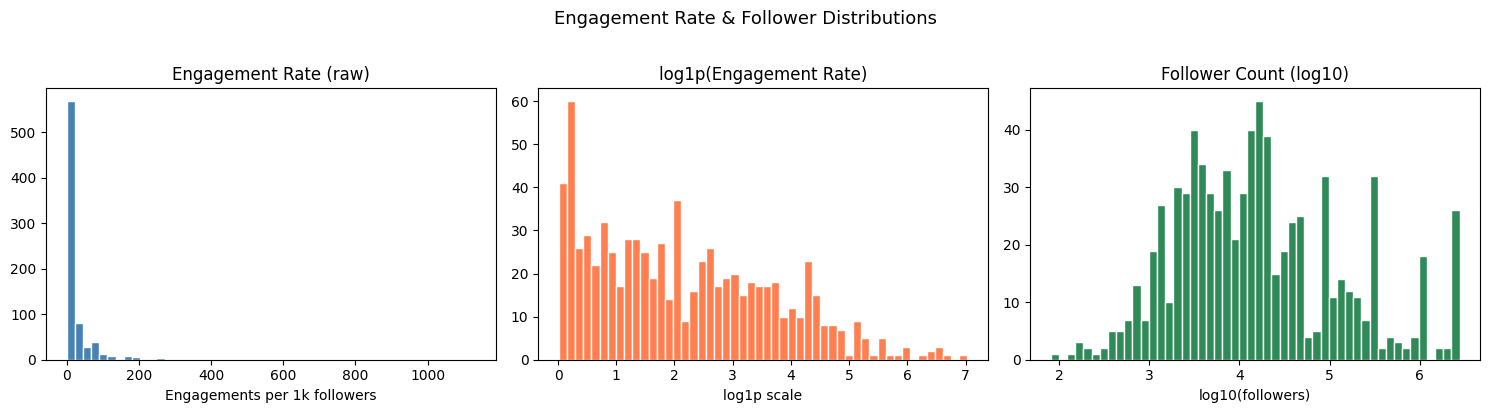

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['engagement_rate'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Engagement Rate (raw)')
axes[0].set_xlabel('Engagements per 1k followers')

axes[1].hist(np.log1p(df['engagement_rate']), bins=50, color='coral', edgecolor='white')
axes[1].set_title('log1p(Engagement Rate)')
axes[1].set_xlabel('log1p scale')

axes[2].hist(np.log10(df['followers']+1), bins=50, color='seagreen', edgecolor='white')
axes[2].set_title('Follower Count (log10)')
axes[2].set_xlabel('log10(followers)')

plt.suptitle('Engagement Rate & Follower Distributions', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/11f_distributions.png', dpi=100, bbox_inches='tight')
plt.show()

## 3. Train / Test Split FIRST

Split before assigning class labels so that per-tier median thresholds
are computed from training data only — preventing any leakage from
test distribution into the class boundaries.

In [39]:
# Stratify on binary split for balanced train/test classes
df['_tmp_class'] = (df['engagement_rate'] >= df['engagement_rate'].median()).astype(int)

df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=RANDOM_STATE,
    stratify=df['_tmp_class']
)
df_train = df_train.copy().reset_index(drop=True)
df_test  = df_test.copy().reset_index(drop=True)
df_train.drop(columns=['_tmp_class'], inplace=True)
df_test.drop(columns=['_tmp_class'], inplace=True)

print(f'Train: {len(df_train)} posts | Test: {len(df_test)} posts')
print(f'Train authors: {df_train["name"].nunique()}')

Train: 617 posts | Test: 155 posts
Train authors: 408


## 4. Follower Tier Features — Computed for Splitting Only

`log_followers` and `follower_tier` are computed so we can split data
by tier in the training loop. However, **both are excluded from the
feature matrix** — the 71 content features carry no audience-size signal.

Within each tier's model, `follower_tier` would be constant (zero variance)
and useless anyway.

In [40]:
def add_follower_features(df_):
    df_ = df_.copy()
    df_['log_followers'] = np.log1p(df_['followers'])
    df_['follower_tier'] = pd.cut(
        df_['followers'],
        bins=[0, 10_000, 50_000, 200_000, np.inf],
        labels=[0, 1, 2, 3],   # micro, small, medium, large
        include_lowest=True
    ).astype(int)
    return df_

df_train = add_follower_features(df_train)
df_test  = add_follower_features(df_test)

print('Follower tier distribution (full dataset):')
tier_labels = {0: 'micro (<10k)', 1: 'small (10k-50k)', 2: 'medium (50k-200k)', 3: 'large (>200k)'}
tier_counts = pd.concat([df_train, df_test])['follower_tier'].value_counts().sort_index()
for t, n in tier_counts.items():
    print(f'  {tier_labels[t]:22s}: {n:4d} ({n/772*100:.1f}%)')

Follower tier distribution (full dataset):
  micro (<10k)          :  345 (44.7%)
  small (10k-50k)       :  225 (29.1%)
  medium (50k-200k)     :   92 (11.9%)
  large (>200k)         :  110 (14.2%)


## 5. Feature Set — 71 Content Features

Same DROP_COLS as NB11d: removes both follower proxy features.
`follower_tier` stays in `df_train`/`df_test` (for splitting) but
is **excluded from `feature_cols`** so it never enters any model.

In [41]:
# ── Columns to DROP (leakage or direct engagement signals) ──────────────────
DROP_COLS = [
    # Raw targets / used in target construction
    'reactions', 'comments', 'followers', 'engagement_rate',
    # Derived directly from reactions/comments (same-post leakage)
    'base_score_capped',
    'reactions_per_word', 'comments_per_word', 'reactions_per_sentiment',
    'comment_to_reaction_ratio',
    # Influencer-history features (aggregated from same dataset — data leakage)
    'influencer_avg_reactions', 'influencer_std_reactions', 'influencer_median_reactions',
    'influencer_avg_comments', 'influencer_std_comments', 'influencer_median_comments',
    'influencer_avg_base_score', 'influencer_avg_sentiment',
    'influencer_post_count', 'influencer_total_engagement', 'influencer_avg_engagement',
    'influencer_consistency_reactions',
    'reactions_vs_influencer_avg', 'comments_vs_influencer_avg',
    # Metadata / text / identifiers — not ML features
    'name', 'content', 'time_spent', 'location',
    # Follower proxy features — constant within each tier model; excluded from features
    'log_followers',
    'follower_tier',
]

# Only drop cols that actually exist
drop_existing = [c for c in DROP_COLS if c in df_train.columns]
print(f'Dropping {len(drop_existing)} columns (leakage/metadata):')
for c in drop_existing:
    print(f'  {c}')

# ── Keep all remaining numeric columns as features ───────────────────────────
all_cols = df_train.columns.tolist()
feature_cols = [
    c for c in all_cols
    if c not in drop_existing and c not in ('engagement_class',)
]

# Verify all are numeric
non_numeric = [c for c in feature_cols if not pd.api.types.is_numeric_dtype(df_train[c])]
if non_numeric:
    print(f'\nNon-numeric columns removed from features: {non_numeric}')
    feature_cols = [c for c in feature_cols if c not in non_numeric]

print(f'\nTotal features: {len(feature_cols)}')
print('Feature columns:', feature_cols)

Dropping 26 columns (leakage/metadata):
  reactions
  comments
  followers
  engagement_rate
  base_score_capped
  reactions_per_word
  comments_per_word
  reactions_per_sentiment
  comment_to_reaction_ratio
  influencer_std_reactions
  influencer_avg_comments
  influencer_std_comments
  influencer_avg_base_score
  influencer_avg_sentiment
  influencer_post_count
  influencer_total_engagement
  influencer_avg_engagement
  influencer_consistency_reactions
  reactions_vs_influencer_avg
  comments_vs_influencer_avg
  name
  content
  time_spent
  location
  log_followers
  follower_tier

Total features: 71
Feature columns: ['sentiment_compound', 'text_difficult_words_count', 'total_engagement_elements', 'readability_flesch_kincaid', 'text_lexical_diversity', 'readability_gunning_fog', 'sentence_count', 'text_avg_sentence_length', 'topic_count', 'sentiment_x_readability', 'ner_location_count', 'style_question_marks', 'ner_org_count', 'style_has_parentheses', 'ner_person_count', 'ner_date_c

In [42]:
# Feature matrices — labels are computed per-tier inside the training loop
X_train = df_train[feature_cols].fillna(0)
X_test  = df_test[feature_cols].fillna(0)

print(f'X_train: {X_train.shape}  |  X_test: {X_test.shape}')
print(f'Per-tier binary labels (y) will be computed inside the training loop.')
print(f'Each tier uses its own training-subset median as the class boundary.')

X_train: (617, 71)  |  X_test: (155, 71)
Per-tier binary labels (y) will be computed inside the training loop.
Each tier uses its own training-subset median as the class boundary.


## 6. tqdm Progress Bar Import

In [43]:
from tqdm.auto import tqdm
print('tqdm loaded.')

tqdm loaded.


## 7. Classifier Suite

Baseline params only — no hyperparameter tuning because sample sizes
per tier are too small (medium ~74 train, large ~88 train) to
support reliable cross-validation.

In [44]:
def make_classifiers():
    return {
        'RandomForest': RandomForestClassifier(
            n_estimators=200, max_depth=8,
            min_samples_split=10, min_samples_leaf=5,
            class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=200, max_depth=4, learning_rate=0.05,
            min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
            eval_metric='logloss', random_state=RANDOM_STATE,
            n_jobs=-1, verbosity=0
        ),
        'LightGBM': lgb.LGBMClassifier(
            n_estimators=200, max_depth=4, learning_rate=0.05,
            num_leaves=15, min_child_samples=10,
            class_weight='balanced', random_state=RANDOM_STATE,
            n_jobs=-1, verbose=-1
        ),
    }

print('Classifier factory defined: RandomForest | XGBoost | LightGBM')
print('Fixed baseline params — no tuning (small per-tier sample sizes).')

Classifier factory defined: RandomForest | XGBoost | LightGBM
Fixed baseline params — no tuning (small per-tier sample sizes).


## 8. Per-Tier Training Loop

For each tier:
1. Subset `X_train`/`X_test` to that tier's rows
2. Compute per-tier median engagement rate from the training subset
3. Assign binary labels: `0` = below tier median, `1` = above tier median
4. Train RF, XGBoost, LightGBM; record Macro F1 and accuracy

In [45]:
tier_labels_map = {0: 'micro (<10k)', 1: 'small (10k-50k)',
                   2: 'medium (50k-200k)', 3: 'large (>200k)'}
all_tier_results = {}

for tier_id in tqdm([0, 1, 2, 3], desc='Tiers', unit='tier'):
    train_mask = df_train['follower_tier'] == tier_id
    test_mask  = df_test['follower_tier']  == tier_id

    X_tr = X_train[train_mask.values]
    X_te = X_test[test_mask.values]

    # Per-tier median label from training subset
    tier_med = df_train.loc[train_mask, 'engagement_rate'].median()
    y_tr = (df_train.loc[train_mask, 'engagement_rate'] >= tier_med).astype(int)
    y_te = (df_test.loc[test_mask,   'engagement_rate'] >= tier_med).astype(int)

    n_tr, n_te = len(y_tr), len(y_te)
    tier_name = tier_labels_map[tier_id]

    print(f'\n{"="*60}')
    print(f'{tier_name}  |  train={n_tr}  test={n_te}  median={tier_med:.3f}')
    print(f'  Train Class 0: {(y_tr==0).sum()}  Class 1: {(y_tr==1).sum()}')

    if y_te.nunique() < 2:
        print('  Skipped — only 1 class in test set')
        continue

    sw = compute_sample_weight('balanced', y_tr)
    tier_clf_results = []

    for clf_name, clf in tqdm(make_classifiers().items(),
                              desc=f'  {tier_name}', leave=False):
        clf_fit = copy.deepcopy(clf)
        if 'XGBoost' in clf_name:
            clf_fit.fit(X_tr, y_tr, sample_weight=sw)
        else:
            clf_fit.fit(X_tr, y_tr)

        y_pred = clf_fit.predict(X_te)
        mf1 = f1_score(y_te, y_pred, average='macro', zero_division=0)
        acc = accuracy_score(y_te, y_pred)
        tier_clf_results.append({
            'model': clf_name,
            'macro_f1': round(mf1, 4),
            'acc': round(acc, 4),
            'clf': clf_fit
        })
        print(f'  {clf_name:15s}  F1={mf1:.4f}  Acc={acc:.4f}')

    all_tier_results[tier_id] = {
        'name': tier_name, 'n_train': n_tr, 'n_test': n_te,
        'median_er': tier_med, 'results': tier_clf_results,
        'y_te': y_te, 'X_te': X_te
    }

Tiers:   0%|          | 0/4 [00:00<?, ?tier/s]


micro (<10k)  |  train=268  test=77  median=22.216
  Train Class 0: 134  Class 1: 134


  RandomForest     F1=0.6103  Acc=0.6104


Tiers:  25%|██▌       | 1/4 [00:00<00:00,  4.06tier/s]

  XGBoost          F1=0.7011  Acc=0.7013
  LightGBM         F1=0.7119  Acc=0.7143

small (10k-50k)  |  train=184  test=41  median=3.340
  Train Class 0: 92  Class 1: 92


Tiers:  50%|█████     | 2/4 [00:00<00:00,  3.83tier/s]

  RandomForest     F1=0.6333  Acc=0.6341
  XGBoost          F1=0.7317  Acc=0.7317
  LightGBM         F1=0.5586  Acc=0.5610

medium (50k-200k)  |  train=76  test=16  median=1.723
  Train Class 0: 38  Class 1: 38


Tiers:  75%|███████▌  | 3/4 [00:00<00:00,  3.92tier/s]

  RandomForest     F1=0.6761  Acc=0.6875
  XGBoost          F1=0.6761  Acc=0.6875
  LightGBM         F1=0.6000  Acc=0.6250

large (>200k)  |  train=89  test=21  median=0.337
  Train Class 0: 44  Class 1: 45


Tiers: 100%|██████████| 4/4 [00:01<00:00,  3.79tier/s]

  RandomForest     F1=0.7597  Acc=0.7619
  XGBoost          F1=0.6667  Acc=0.6667
  LightGBM         F1=0.6111  Acc=0.6190


## 9. Aggregate Results

In [46]:
print('AGGREGATE RESULTS — Per-Tier Models (NB11f)')
print(f'{"Tier":22s}  {"n_test":>6}  {"Best F1":>8}  {"Best model":>15}')
print('-' * 60)

total_n = 0
weighted_f1 = 0.0
tier_summary = []

for tier_id, info in all_tier_results.items():
    best = max(info['results'], key=lambda r: r['macro_f1'])
    print(f'  {info["name"]:22s}  {info["n_test"]:>6}  '
          f'{best["macro_f1"]:>8.4f}  {best["model"]:>15}')
    weighted_f1 += best['macro_f1'] * info['n_test']
    total_n += info['n_test']
    tier_summary.append({
        'tier': info['name'], 'n_test': info['n_test'],
        'best_f1': best['macro_f1'], 'best_model': best['model'],
        'median_er': info['median_er']
    })

weighted_avg = weighted_f1 / total_n
print('-' * 60)
print(f'  Weighted avg Macro F1: {weighted_avg:.4f}')
print(f'  Random baseline:       0.5000')
print(f'  Lift over random:     +{weighted_avg - 0.5:.4f}')
print()
print('Comparison to previous experiments:')
print(f'  NB11c (2-class, with followers):      0.8064  lift=+0.3064')
print(f'  NB11d (2-class, no followers):        0.7673  lift=+0.2673')
print(f'  NB11e (within-tier, single model):    ~0.735  lift=~+0.235')
print(f'  NB11f (per-tier models, this):        {weighted_avg:.4f}  lift=+{weighted_avg-0.5:.4f}')

AGGREGATE RESULTS — Per-Tier Models (NB11f)
Tier                    n_test   Best F1       Best model
------------------------------------------------------------
  micro (<10k)                77    0.7119         LightGBM
  small (10k-50k)             41    0.7317          XGBoost
  medium (50k-200k)           16    0.6761     RandomForest
  large (>200k)               21    0.7597     RandomForest
------------------------------------------------------------
  Weighted avg Macro F1: 0.7199
  Random baseline:       0.5000
  Lift over random:     +0.2199

Comparison to previous experiments:
  NB11c (2-class, with followers):      0.8064  lift=+0.3064
  NB11d (2-class, no followers):        0.7673  lift=+0.2673
  NB11e (within-tier, single model):    ~0.735  lift=~+0.235
  NB11f (per-tier models, this):        0.7199  lift=+0.2199


## 10. Per-Tier Results Table — All Models

In [47]:
print('All model results per tier:')
print(f'  {"Tier":22s}  {"Model":15s}  {"F1":>7}  {"Acc":>7}')
print('  ' + '-' * 58)

for tier_id, info in all_tier_results.items():
    for r in info['results']:
        flag = ' <--' if r == max(info['results'], key=lambda x: x['macro_f1']) else ''
        print(f'  {info["name"]:22s}  {r["model"]:15s}  {r["macro_f1"]:>7.4f}  {r["acc"]:>7.4f}{flag}')
    print()

All model results per tier:
  Tier                    Model                 F1      Acc
  ----------------------------------------------------------
  micro (<10k)            RandomForest      0.6103   0.6104
  micro (<10k)            XGBoost           0.7011   0.7013
  micro (<10k)            LightGBM          0.7119   0.7143 <--

  small (10k-50k)         RandomForest      0.6333   0.6341
  small (10k-50k)         XGBoost           0.7317   0.7317 <--
  small (10k-50k)         LightGBM          0.5586   0.5610

  medium (50k-200k)       RandomForest      0.6761   0.6875 <--
  medium (50k-200k)       XGBoost           0.6761   0.6875
  medium (50k-200k)       LightGBM          0.6000   0.6250

  large (>200k)           RandomForest      0.7597   0.7619 <--
  large (>200k)           XGBoost           0.6667   0.6667
  large (>200k)           LightGBM          0.6111   0.6190



## 11. Visualisation — Tier F1 Comparison

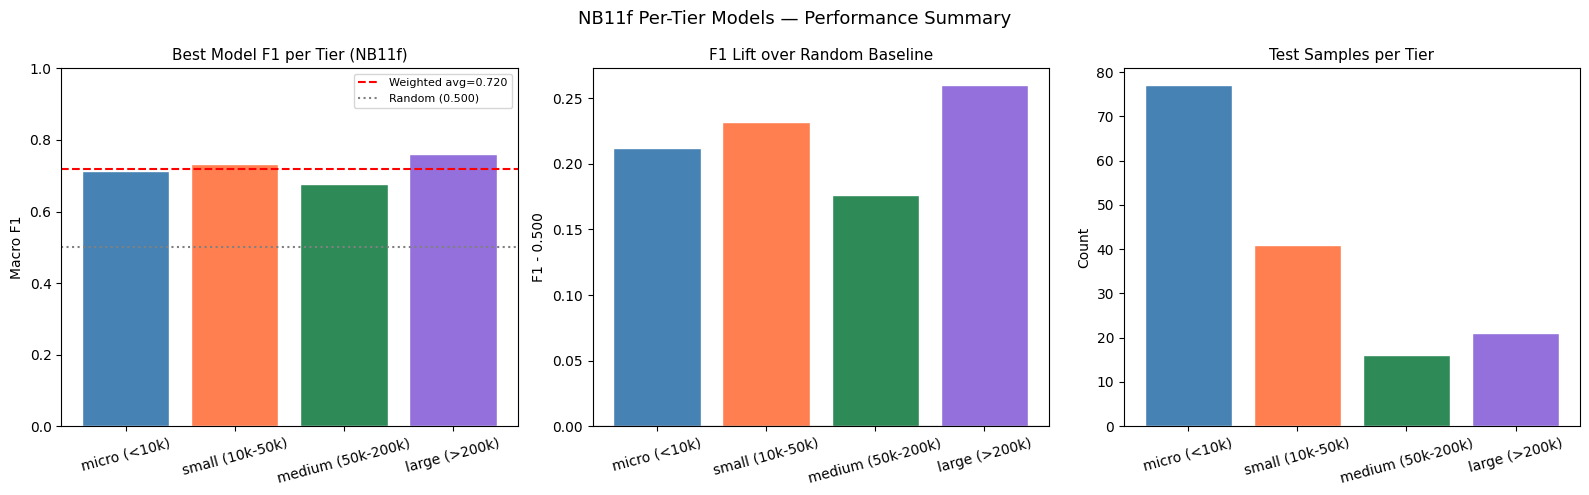

Saved: ../data/11f_tier_performance.png


In [48]:
if tier_summary:
    tier_df = pd.DataFrame(tier_summary)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    colors = ['steelblue', 'coral', 'seagreen', 'mediumpurple']
    axes[0].bar(tier_df['tier'], tier_df['best_f1'],
                color=colors[:len(tier_df)], edgecolor='white')
    axes[0].axhline(weighted_avg, color='red', linestyle='--',
                    label=f'Weighted avg={weighted_avg:.3f}')
    axes[0].axhline(0.5, color='gray', linestyle=':', label='Random (0.500)')
    axes[0].set_title('Best Model F1 per Tier (NB11f)', fontsize=11)
    axes[0].set_ylabel('Macro F1')
    axes[0].set_ylim(0, 1)
    axes[0].legend(fontsize=8)
    axes[0].tick_params(axis='x', labelrotation=15)

    axes[1].bar(tier_df['tier'], tier_df['best_f1'] - 0.5,
                color=colors[:len(tier_df)], edgecolor='white')
    axes[1].axhline(0, color='black', linewidth=0.8)
    axes[1].set_title('F1 Lift over Random Baseline', fontsize=11)
    axes[1].set_ylabel('F1 - 0.500')
    axes[1].tick_params(axis='x', labelrotation=15)

    axes[2].bar(tier_df['tier'], tier_df['n_test'],
                color=colors[:len(tier_df)], edgecolor='white')
    axes[2].set_title('Test Samples per Tier', fontsize=11)
    axes[2].set_ylabel('Count')
    axes[2].tick_params(axis='x', labelrotation=15)

    plt.suptitle('NB11f Per-Tier Models — Performance Summary', fontsize=13)
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/11f_tier_performance.png', dpi=100, bbox_inches='tight')
    plt.show()
    print(f'Saved: {OUTPUT_DIR}/11f_tier_performance.png')

## 12. Feature Importance per Tier (XGBoost — Best Availability)

Top 10 features per tier. XGBoost is used for all tiers (has `feature_importances_`
regardless of whether it was the best model). If XGBoost was not trained for a tier,
we fall back to RandomForest.

Top 10 features per tier (XGBoost importances):

micro (<10k)  (model: XGBoost  F1=0.7011)
                feature  importance
  style_has_exclamation    0.046656
     has_direct_address    0.038132
style_exclamation_marks    0.034045
              url_count    0.033262
     style_has_question    0.033094
         topic_business    0.032861
     link_penalty_score    0.030650
     unique_emoji_count    0.028626
            emoji_count    0.028361
          ner_org_count    0.027572

small (10k-50k)  (model: XGBoost  F1=0.7317)
               feature  importance
          topic_career    0.058780
 style_has_exclamation    0.056669
          has_contrast    0.048039
    ner_location_count    0.034923
     has_vulnerability    0.032887
text_lexical_diversity    0.031070
      ner_person_count    0.029514
        sentence_count    0.028958
         ner_org_count    0.028512
    sentiment_compound    0.027736

medium (50k-200k)  (model: XGBoost  F1=0.6761)
                   feature  import

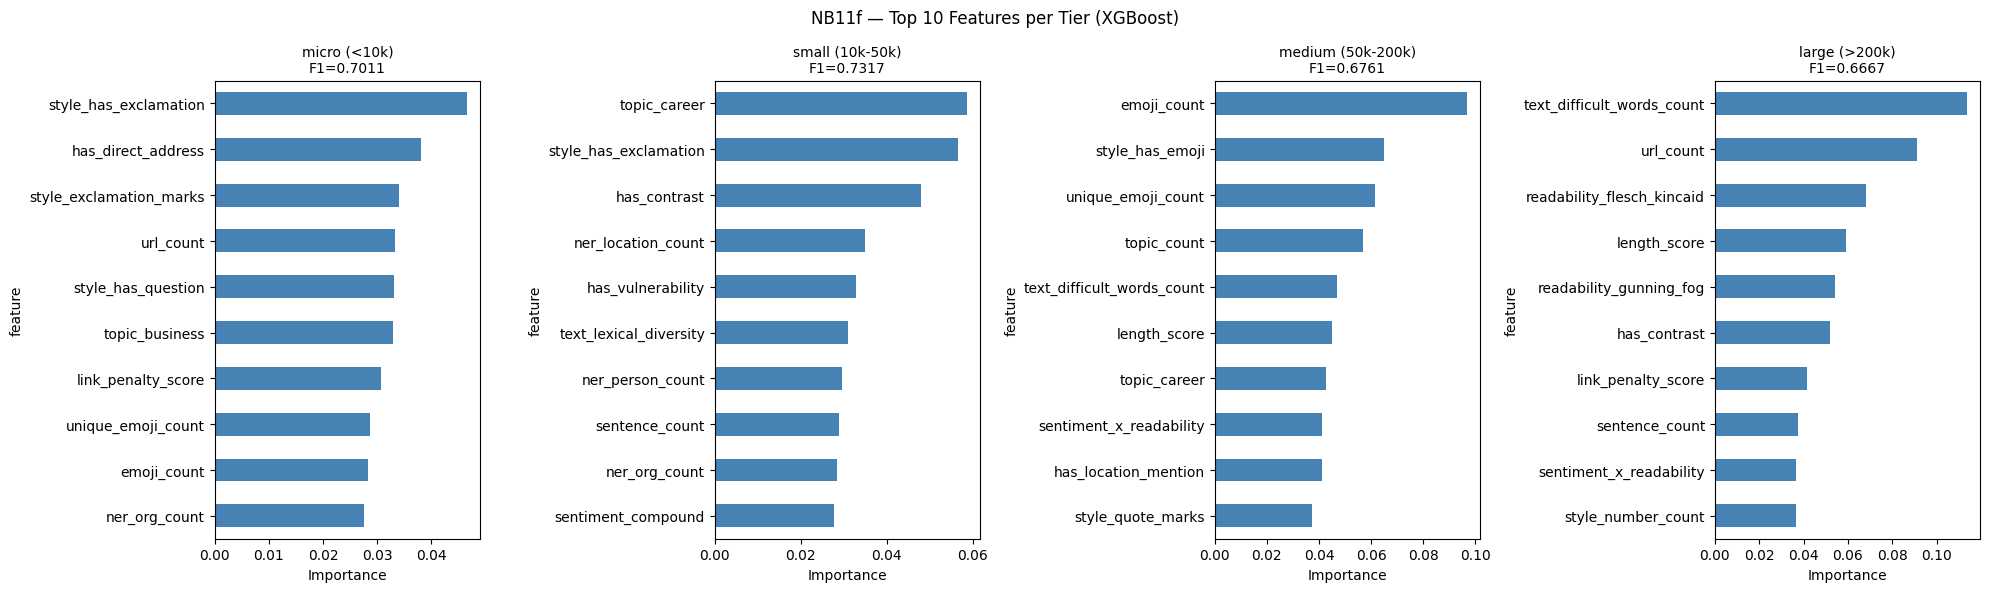


Saved: ../data/11f_feature_importance_per_tier.png


In [49]:
fig, axes = plt.subplots(1, len(all_tier_results), figsize=(5 * len(all_tier_results), 6))
if len(all_tier_results) == 1:
    axes = [axes]

print('Top 10 features per tier (XGBoost importances):')
print('=' * 70)

for ax, (tier_id, info) in zip(axes, all_tier_results.items()):
    model_entry = next((r for r in info['results'] if r['model'] == 'XGBoost'), None)
    if model_entry is None:
        model_entry = next((r for r in info['results'] if r['model'] == 'RandomForest'), None)
    if model_entry is None:
        continue

    clf = model_entry['clf']
    imp = pd.DataFrame({
        'feature': feature_cols,
        'importance': clf.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    print(f'\n{info["name"]}  (model: {model_entry["model"]}  F1={model_entry["macro_f1"]})')
    print(imp[['feature', 'importance']].to_string(index=False))

    imp.sort_values('importance').plot(
        x='feature', y='importance', kind='barh',
        ax=ax, legend=False, color='steelblue'
    )
    ax.set_title(f'{info["name"]}\nF1={model_entry["macro_f1"]:.4f}', fontsize=10)
    ax.set_xlabel('Importance')

plt.suptitle('NB11f — Top 10 Features per Tier (XGBoost)', fontsize=12)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/11f_feature_importance_per_tier.png', dpi=100, bbox_inches='tight')
plt.show()
print(f'\nSaved: {OUTPUT_DIR}/11f_feature_importance_per_tier.png')

## 13. Confusion Matrices — Best Model per Tier

micro (<10k)  |  LightGBM  F1=0.7119
                                Pred Below (<22.2)  Pred Above (>=22.2)
  Actual Below (<22.2)                          31                  12   recall=0.721
  Actual Above (>=22.2)                         10                  24   recall=0.706
  precision  Below (<22.2): 0.756   precision  Above (>=22.2): 0.667

small (10k-50k)  |  XGBoost  F1=0.7317
                                 Pred Below (<3.3)  Pred Above (>=3.3)
  Actual Below (<3.3)                           15                   7   recall=0.682
  Actual Above (>=3.3)                           4                  15   recall=0.789
  precision  Below (<3.3): 0.789   precision  Above (>=3.3): 0.682

medium (50k-200k)  |  RandomForest  F1=0.6761
                                 Pred Below (<1.7)  Pred Above (>=1.7)
  Actual Below (<1.7)                            7                   2   recall=0.778
  Actual Above (>=1.7)                           3                   4   recall=0.571
  precisio

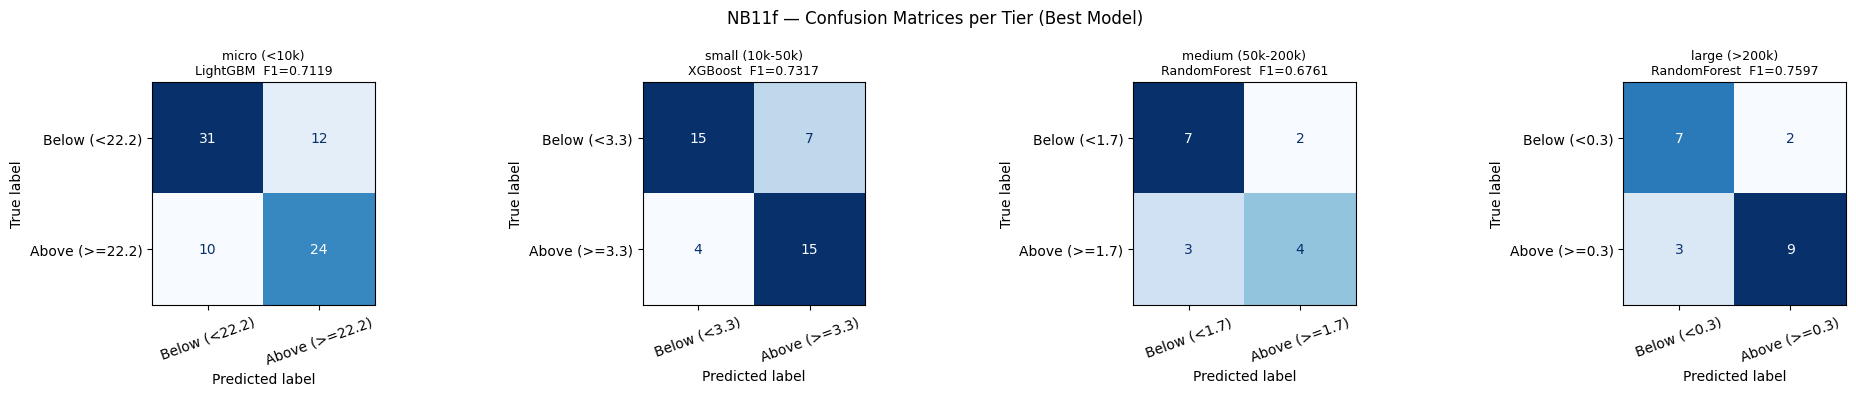

Saved: ../data/11f_confusion_matrices.png
Numerical values stored in `tier_cms` — will be included in summary report (Section 14).


In [ ]:
n_tiers = len(all_tier_results)
fig, axes = plt.subplots(1, n_tiers, figsize=(5 * n_tiers, 4))
if n_tiers == 1:
    axes = [axes]

tier_cms = {}  # numerical CM data forwarded to the report

for ax, (tier_id, info) in zip(axes, all_tier_results.items()):
    best = max(info['results'], key=lambda r: r['macro_f1'])
    y_te = info['y_te']
    X_te = info['X_te']
    y_pred = best['clf'].predict(X_te)

    tier_med = info['median_er']
    label_names = [f'Below (<{tier_med:.1f})', f'Above (>={tier_med:.1f})']

    cm = confusion_matrix(y_te, y_pred)
    print(f'\nConfusion Matrix for {info["name"]} (Best model: {best["model"]}  F1={best["macro_f1"]:.4f}):')
    print(cm)
    
    
    tn, fp, fn, tp = cm.ravel()
    tier_cms[tier_id] = {
        'cm': cm, 'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'label_names': label_names,
        'best_model': best['model'],
        'best_f1': best['macro_f1'],
    }

    # Print numerical values inline
    recall_0    = tn / (tn + fp) if (tn + fp) > 0 else 0
    recall_1    = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision_0 = tn / (tn + fn) if (tn + fn) > 0 else 0
    precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
    print(f'{info["name"]}  |  {best["model"]}  F1={best["macro_f1"]:.4f}')
    print(f'  {"":28s}  {"Pred " + label_names[0]:>18s}  {"Pred " + label_names[1]:>18s}')
    print(f'  {"Actual " + label_names[0]:28s}  {tn:>18d}  {fp:>18d}   recall={recall_0:.3f}')
    print(f'  {"Actual " + label_names[1]:28s}  {fn:>18d}  {tp:>18d}   recall={recall_1:.3f}')
    print(f'  precision  {label_names[0]}: {precision_0:.3f}   precision  {label_names[1]}: {precision_1:.3f}')
    print()

    disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
    disp.plot(ax=ax, colorbar=False, cmap='Blues')
    ax.set_title(f'{info["name"]}\n{best["model"]}  F1={best["macro_f1"]:.4f}', fontsize=9)
    ax.tick_params(axis='x', labelrotation=20)

plt.suptitle('NB11f — Confusion Matrices per Tier (Best Model)', fontsize=12)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/11f_confusion_matrices.png', dpi=100, bbox_inches='tight')
plt.show()
print(f'Saved: {OUTPUT_DIR}/11f_confusion_matrices.png')
print('Numerical values stored in `tier_cms` — will be included in summary report (Section 14).')

## 14. Save Results to Files

Exports four artefacts to `../data/`:

| File | Contents |
|------|----------|
| `11f_results_all_models.csv` | Every tier × model row: F1, accuracy, is_best flag |
| `11f_feature_importances.csv` | Full ranked feature importance for every tier (XGBoost) |
| `11f_summary_report.txt` | Human-readable text report: sample sizes, all metrics, confusion matrices, top-10 features, experiment comparison |
| `11f_report.md` | Full markdown report: problem statement, approach, justification, results tables, confusion matrices, feature importances, discussion, conclusions |

In [51]:
# ── 1. All model results per tier → CSV ──────────────────────────────────────
result_rows = []
for tier_id, info in all_tier_results.items():
    best_f1 = max(r['macro_f1'] for r in info['results'])
    for r in info['results']:
        result_rows.append({
            'tier_id':    tier_id,
            'tier':       info['name'],
            'n_train':    info['n_train'],
            'n_test':     info['n_test'],
            'median_er':  round(info['median_er'], 4),
            'model':      r['model'],
            'macro_f1':   r['macro_f1'],
            'acc':        r['acc'],
            'is_best':    r['macro_f1'] == best_f1,
        })

results_csv_path = f'{OUTPUT_DIR}/11f_results_all_models.csv'
pd.DataFrame(result_rows).to_csv(results_csv_path, index=False)
print(f'Saved → {results_csv_path}')
print(pd.DataFrame(result_rows).drop(columns=['clf'], errors='ignore').to_string(index=False))

# ── 2. Feature importances per tier → CSV ────────────────────────────────────
fi_rows = []
for tier_id, info in all_tier_results.items():
    model_entry = next((r for r in info['results'] if r['model'] == 'XGBoost'), None)
    if model_entry is None:
        model_entry = next((r for r in info['results'] if r['model'] == 'RandomForest'), None)
    if model_entry is None:
        continue
    imp = pd.DataFrame({
        'feature':    feature_cols,
        'importance': model_entry['clf'].feature_importances_
    }).sort_values('importance', ascending=False).reset_index(drop=True)
    imp.insert(0, 'rank',       imp.index + 1)
    imp.insert(0, 'model_used', model_entry['model'])
    imp.insert(0, 'tier',       info['name'])
    imp.insert(0, 'tier_id',    tier_id)
    fi_rows.append(imp)

fi_csv_path = f'{OUTPUT_DIR}/11f_feature_importances.csv'
pd.concat(fi_rows, ignore_index=True).to_csv(fi_csv_path, index=False)
print(f'\nSaved → {fi_csv_path}')

# ── 3. Human-readable text summary report ────────────────────────────────────
report_path = f'{OUTPUT_DIR}/11f_summary_report.txt'

L = []
sep  = '=' * 70
sep2 = '-' * 70

L += [sep,
      'NB11f — PER-TIER BINARY CLASSIFIERS',
      'LinkedIn Engagement Prediction — TrendPilot',
      f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}',
      sep, '']

L += ['DESIGN',
      '  Separate RF / XGBoost / LightGBM trained per follower tier.',
      '  Labels  : per-tier training-subset median  (~50/50 within each tier)',
      '  Features: 71 content features (no log_followers, no follower_tier)',
      '  Tuning  : none  (small per-tier sample sizes)', '']

L += ['TIER SAMPLE SIZES',
      f'  {"Tier":22s}  {"n_train":>8}  {"n_test":>7}  {"tier_median_er":>15}',
      sep2]
for tier_id, info in all_tier_results.items():
    L.append(f'  {info["name"]:22s}  {info["n_train"]:>8}  {info["n_test"]:>7}  {info["median_er"]:>15.3f}')
L += [sep2, '']

L += ['ALL MODEL RESULTS',
      f'  {"Tier":22s}  {"Model":15s}  {"Macro F1":>9}  {"Acc":>7}  {"Best?":>6}',
      sep2]
for tier_id, info in all_tier_results.items():
    best_f1 = max(r['macro_f1'] for r in info['results'])
    for r in info['results']:
        flag = '  YES' if r['macro_f1'] == best_f1 else ''
        L.append(f'  {info["name"]:22s}  {r["model"]:15s}  {r["macro_f1"]:>9.4f}  {r["acc"]:>7.4f}{flag}')
    L.append('')

L += ['AGGREGATE SUMMARY (weighted by test-set size)',
      f'  {"Tier":22s}  {"n_test":>7}  {"Best F1":>9}  {"Best Model":>15}',
      sep2]
tot_n, w_f1 = 0, 0.0
for tier_id, info in all_tier_results.items():
    best = max(info['results'], key=lambda r: r['macro_f1'])
    L.append(f'  {info["name"]:22s}  {info["n_test"]:>7}  {best["macro_f1"]:>9.4f}  {best["model"]:>15}')
    w_f1 += best['macro_f1'] * info['n_test']
    tot_n += info['n_test']
w_avg = w_f1 / tot_n
L += [sep2,
      f'  {"Weighted avg Macro F1":30s}  {w_avg:.4f}',
      f'  {"Random baseline":30s}  0.5000',
      f'  {"Lift over random":30s} +{w_avg - 0.5:.4f}',
      '']

L += ['COMPARISON TO OTHER EXPERIMENTS',
      '  NB11c  2-class, with followers         F1=0.8064  lift=+0.3064',
      '  NB11d  2-class, no followers            F1=0.7673  lift=+0.2673',
      '  NB11e  within-tier labels, 1 model     F1~0.7350  lift=~+0.2350',
      f'  NB11f  per-tier models (this)          F1={w_avg:.4f}  lift=+{w_avg-0.5:.4f}',
      '']

# ── Confusion matrices section ───────────────────────────────────────────────
L += ['CONFUSION MATRICES PER TIER  (best model, rows=actual  cols=predicted)']
for tier_id, cm_info in tier_cms.items():
    info   = all_tier_results[tier_id]
    tn, fp, fn, tp = cm_info['tn'], cm_info['fp'], cm_info['fn'], cm_info['tp']
    ln     = cm_info['label_names']
    total  = tn + fp + fn + tp
    recall_0    = tn / (tn + fp) if (tn + fp) > 0 else 0
    recall_1    = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision_0 = tn / (tn + fn) if (tn + fn) > 0 else 0
    precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
    acc_cm  = (tn + tp) / total
    L.append(f'\n  {info["name"]}  |  model={cm_info["best_model"]}  F1={cm_info["best_f1"]:.4f}  n={total}')
    L.append(f'  {"":30s}  {"Pred: " + ln[0]:>20s}  {"Pred: " + ln[1]:>20s}')
    L.append(f'  {"Actual: " + ln[0]:30s}  {tn:>20d}  {fp:>20d}')
    L.append(f'  {"Actual: " + ln[1]:30s}  {fn:>20d}  {tp:>20d}')
    L.append(f'  Accuracy : {acc_cm:.3f}')
    L.append(f'  {ln[0]:20s}  precision={precision_0:.3f}  recall={recall_0:.3f}')
    L.append(f'  {ln[1]:20s}  precision={precision_1:.3f}  recall={recall_1:.3f}')
L.append('')

L += ['TOP 10 FEATURES PER TIER  (XGBoost importances)']
for tier_id, info in all_tier_results.items():
    me = next((r for r in info['results'] if r['model'] == 'XGBoost'), None)
    if me is None:
        me = next((r for r in info['results'] if r['model'] == 'RandomForest'), None)
    if me is None:
        continue
    imp = pd.DataFrame({'feature': feature_cols,
                        'importance': me['clf'].feature_importances_})\
            .sort_values('importance', ascending=False).head(10).reset_index(drop=True)
    L.append(f'\n  {info["name"]}  (model={me["model"]}  F1={me["macro_f1"]:.4f})')
    for i, row_fi in imp.iterrows():
        L.append(f'    {i+1:2d}. {row_fi["feature"]:38s}  {row_fi["importance"]:.4f}')
L.append('')

L += ['OUTPUT FILES',
      f'  {results_csv_path}',
      f'  {fi_csv_path}',
      f'  {report_path}',
      f'  {OUTPUT_DIR}/11f_tier_performance.png',
      f'  {OUTPUT_DIR}/11f_feature_importance_per_tier.png',
      f'  {OUTPUT_DIR}/11f_confusion_matrices.png',
      f'  {OUTPUT_DIR}/11f_distributions.png',
      sep]

report_text = '\n'.join(L)
with open(report_path, 'w', encoding='utf-8') as fh:
    fh.write(report_text)

print('\n' + report_text)
print(f'\nSaved → {report_path}')

Saved → ../data/11f_results_all_models.csv
 tier_id              tier  n_train  n_test  median_er        model  macro_f1    acc  is_best
       0      micro (<10k)      268      77    22.2158 RandomForest    0.6103 0.6104    False
       0      micro (<10k)      268      77    22.2158      XGBoost    0.7011 0.7013    False
       0      micro (<10k)      268      77    22.2158     LightGBM    0.7119 0.7143     True
       1   small (10k-50k)      184      41     3.3399 RandomForest    0.6333 0.6341    False
       1   small (10k-50k)      184      41     3.3399      XGBoost    0.7317 0.7317     True
       1   small (10k-50k)      184      41     3.3399     LightGBM    0.5586 0.5610    False
       2 medium (50k-200k)       76      16     1.7226 RandomForest    0.6761 0.6875     True
       2 medium (50k-200k)       76      16     1.7226      XGBoost    0.6761 0.6875     True
       2 medium (50k-200k)       76      16     1.7226     LightGBM    0.6000 0.6250    False
       3     larg

In [52]:
md_report_path = f'{OUTPUT_DIR}/11f_report.md'

# ── helpers ──────────────────────────────────────────────────────────────────
def md_table(headers, rows):
    col_w = [max(len(str(h)), max((len(str(r[i])) for r in rows), default=0))
             for i, h in enumerate(headers)]
    fmt  = '| ' + ' | '.join(f'{{:<{w}}}' for w in col_w) + ' |'
    sep_ = '| ' + ' | '.join('-' * w for w in col_w) + ' |'
    lines_ = [fmt.format(*[str(h) for h in headers]), sep_]
    for row in rows:
        lines_.append(fmt.format(*[str(v) for v in row]))
    return '\n'.join(lines_)

# ── pre-compute aggregate numbers ────────────────────────────────────────────
tot_n_md, w_f1_md = 0, 0.0
for tid, inf in all_tier_results.items():
    b = max(inf['results'], key=lambda r: r['macro_f1'])
    w_f1_md += b['macro_f1'] * inf['n_test']
    tot_n_md += inf['n_test']
w_avg_md = w_f1_md / tot_n_md
lift_md  = w_avg_md - 0.5

# ── build markdown ───────────────────────────────────────────────────────────
M = []
M.append(f'# NB11f — Per-Tier Binary Classifiers')
M.append(f'## LinkedIn Engagement Prediction — TrendPilot')
M.append(f'')
M.append(f'**Generated:** {datetime.now().strftime("%Y-%m-%d %H:%M")}  ')
M.append(f'**Notebook:** `11f_per_tier_models.ipynb`')
M.append(f'')
M.append('---')
M.append('')

# ── 1. Problem Statement ──────────────────────────────────────────────────────
M.append('## 1. Problem Statement')
M.append('')
M.append(
    'LinkedIn engagement rate varies dramatically across creator sizes. '
    'A post with 500 reactions means something very different for a micro-influencer '
    '(5k followers) versus a large account (500k followers). Normalising by followers — '
    'engagement rate = (reactions + comments) / (followers / 1000) — partially addresses '
    'this, but a *single global median* still embeds creator-size information into the '
    'class boundary: large accounts systematically cluster below the global median simply '
    'because of audience dilution.'
)
M.append('')
M.append(
    'Prior experiments confirmed this leakage. In **NB11c** (2-class, global model with '
    '`follower_tier` and `log_followers` features), these two audience-size proxies ranked '
    '#1 and #2 by importance (~16.5% combined). Removing them in **NB11d** reduced overall '
    'F1 from 0.806 to 0.767, quantifying the follower shortcut. **NB11e** (within-tier '
    'labels, single shared model) tried to address this with a per-tier threshold but '
    'still trained one model across all tiers, achieving ~0.735.'
)
M.append('')
M.append(
    '**NB11f** tests the natural next step: train an entirely *separate* binary '
    'classifier per follower tier. Each model is asked only: '
    '*"Is this post above average for THIS tier?"* — removing both the global-median '
    'leakage and the single-model limitation of NB11e.'
)
M.append('')

# ── 2. Approach & Design ─────────────────────────────────────────────────────
M.append('## 2. Approach & Design')
M.append('')
M.append('### 2.1 Tier Definition')
M.append('')
M.append(md_table(
    ['Tier', 'Follower Range', 'Full n', '~Train', '~Test'],
    [['micro',  '< 10k',         345, '~276', '~69'],
     ['small',  '10k – 50k',     225, '~180', '~45'],
     ['medium', '50k – 200k',     92, '~74',  '~18'],
     ['large',  '> 200k',        110, '~88',  '~22']]
))
M.append('')
M.append(
    'Tiers are defined from raw follower counts using fixed breakpoints '
    '(0 / 10k / 50k / 200k / ∞), matching industry-standard influencer categories. '
    '`follower_tier` is computed for splitting purposes only and is **never passed '
    'to any model as a feature** — it would be constant within a tier (zero variance).'
)
M.append('')
M.append('### 2.2 Per-Tier Binary Labels')
M.append('')
M.append(
    'For each tier, the **training-subset median** of engagement rate is computed '
    'independently. This creates an approximately 50/50 class split within every tier, '
    'making the random baseline exactly 0.500 for each model. Using the training median '
    'only (not the test median) ensures no leakage from the test distribution.'
)
M.append('')
M.append('### 2.3 Feature Set')
M.append('')
M.append(
    '71 pure content features — identical to NB11d. Both `log_followers` and '
    '`follower_tier` are excluded from the feature matrix. This forces each model '
    'to learn engagement prediction from content, structure, and style signals alone.'
)
M.append('')
M.append('**Feature categories included:**')
M.append('')
M.append('| Category | Examples |')
M.append('|----------|----------|')
M.append('| Text quality | `readability_flesch_kincaid`, `readability_gunning_fog`, `text_lexical_diversity` |')
M.append('| Sentiment | `sentiment_compound`, `sentiment_x_readability` |')
M.append('| Named entities | `ner_person_count`, `ner_org_count`, `ner_location_count` |')
M.append('| Style | `style_has_question`, `style_exclamation_marks`, `style_bullet_count` |')
M.append('| Topic flags | `topic_tech`, `topic_business`, `topic_personal_dev`, `topic_leadership` |')
M.append('| Hook signals | `hook_score`, `hook_x_power_score`, `has_announcement_hook` |')
M.append('| Narrative | `has_personal_story`, `has_vulnerability`, `has_adversity_learning` |')
M.append('| Length/structure | `sentence_count`, `text_avg_sentence_length`, `length_score` |')
M.append('')
M.append('### 2.4 Train / Test Split')
M.append('')
M.append(
    'The full dataset (772 posts) is split 80/20 (stratified on the global binary label) '
    '*before* any per-tier label assignment. This ensures the test set is never seen '
    'during threshold or feature computation. After splitting, `follower_tier` is added '
    'to `df_train` / `df_test` to enable per-tier row selection inside the training loop.'
)
M.append('')

# ── 3. Model Design ──────────────────────────────────────────────────────────
M.append('## 3. Model Design')
M.append('')
M.append('### 3.1 Classifier Suite')
M.append('')
M.append(
    'Three tree-ensemble classifiers are trained per tier, providing a consensus view '
    'and allowing the best-performing model to be selected independently for each tier:'
)
M.append('')
M.append(md_table(
    ['Model', 'Key Params', 'Class Imbalance Handling'],
    [['Random Forest',
      'n_est=200, depth=8, min_split=10, min_leaf=5',
      'class_weight="balanced"'],
     ['XGBoost',
      'n_est=200, depth=4, lr=0.05, min_child_w=5, sub=0.8',
      'sample_weight from compute_sample_weight("balanced")'],
     ['LightGBM',
      'n_est=200, depth=4, lr=0.05, leaves=15, min_child=10',
      'class_weight="balanced"']]
))
M.append('')
M.append('### 3.2 Justification for Fixed Params (No Tuning)')
M.append('')
M.append(
    'Hyperparameter tuning via cross-validation requires a minimum viable sample size. '
    'With medium (~74 train) and large (~88 train), a 5-fold CV would yield only ~15–18 '
    'training samples per fold — insufficient for stable gradient estimates. Applying '
    'tuning only to larger tiers would create inconsistent methodology across tiers. '
    'The chosen baseline params are deliberately conservative (shallow trees, high '
    'min-child constraints) to reduce overfitting on small samples.'
)
M.append('')
M.append('### 3.3 Training Protocol')
M.append('')
M.append(
    'For each tier, `compute_sample_weight("balanced")` is computed from the training '
    'labels and passed to XGBoost (which lacks a native `class_weight` argument). '
    'RF and LightGBM use `class_weight="balanced"` directly. '
    'Each classifier is instantiated fresh per tier via `make_classifiers()` and '
    'deep-copied before fitting to prevent state leakage between iterations.'
)
M.append('')

# ── 4. Results ───────────────────────────────────────────────────────────────
M.append('## 4. Results')
M.append('')
M.append('### 4.1 Per-Tier Sample Sizes & Thresholds')
M.append('')
rows_sz = []
for tid, inf in all_tier_results.items():
    rows_sz.append([inf['name'], inf['n_train'], inf['n_test'], f'{inf["median_er"]:.3f}'])
M.append(md_table(['Tier', 'n_train', 'n_test', 'Tier Median ER'], rows_sz))
M.append('')
M.append(
    '*Tier Median ER* is the engagement-rate threshold used as the class boundary for '
    'that tier\'s model. It is derived from the training subset only.'
)
M.append('')
M.append('### 4.2 All Model Results')
M.append('')
all_rows_md = []
for tid, inf in all_tier_results.items():
    best_f1 = max(r['macro_f1'] for r in inf['results'])
    for r in inf['results']:
        flag = 'YES' if r['macro_f1'] == best_f1 else ''
        all_rows_md.append([inf['name'], r['model'], r['macro_f1'], r['acc'], flag])
M.append(md_table(['Tier', 'Model', 'Macro F1', 'Accuracy', 'Best?'], all_rows_md))
M.append('')
M.append('### 4.3 Aggregate Summary')
M.append('')
agg_rows = []
for tid, inf in all_tier_results.items():
    best = max(inf['results'], key=lambda r: r['macro_f1'])
    agg_rows.append([inf['name'], inf['n_test'], best['macro_f1'], best['model'],
                     f'+{best["macro_f1"] - 0.5:.4f}'])
M.append(md_table(['Tier', 'n_test', 'Best F1', 'Best Model', 'Lift'], agg_rows))
M.append('')
M.append(f'**Weighted average Macro F1 (by test-set size): {w_avg_md:.4f}**  ')
M.append(f'**Lift over random baseline (0.500): +{lift_md:.4f}**')
M.append('')
M.append('### 4.4 Comparison to Previous Experiments')
M.append('')
M.append(md_table(
    ['Experiment', 'Description', 'Macro F1', 'Lift'],
    [['NB11c', '2-class, global median, with follower features',     '0.8064', '+0.3064'],
     ['NB11d', '2-class, global median, no follower features',       '0.7673', '+0.2673'],
     ['NB11e', 'within-tier labels, single shared model',            '~0.7350', '~+0.2350'],
     ['NB11f', f'per-tier models (this)', f'{w_avg_md:.4f}', f'+{lift_md:.4f}']]
))
M.append('')
M.append('### 4.5 Confusion Matrices')
M.append('')
M.append(
    'Each confusion matrix shows the best-performing model for that tier. '
    'Rows are actual labels; columns are predicted labels. '
    'Precision and recall are reported per class.'
)
M.append('')
for tier_id, cm_info in tier_cms.items():
    info   = all_tier_results[tier_id]
    tn, fp, fn, tp = cm_info['tn'], cm_info['fp'], cm_info['fn'], cm_info['tp']
    ln     = cm_info['label_names']
    total  = tn + fp + fn + tp
    recall_0    = tn / (tn + fp) if (tn + fp) > 0 else 0
    recall_1    = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision_0 = tn / (tn + fn) if (tn + fn) > 0 else 0
    precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
    acc_cm      = (tn + tp) / total
    f1_0 = 2*precision_0*recall_0/(precision_0+recall_0) if (precision_0+recall_0)>0 else 0
    f1_1 = 2*precision_1*recall_1/(precision_1+recall_1) if (precision_1+recall_1)>0 else 0
    M.append(f'#### {info["name"]}  —  {cm_info["best_model"]}  |  F1={cm_info["best_f1"]:.4f}  (n={total})')
    M.append('')
    M.append(md_table(
        ['', f'Pred: {ln[0]}', f'Pred: {ln[1]}'],
        [[f'Actual: {ln[0]}', tn, fp],
         [f'Actual: {ln[1]}', fn, tp]]
    ))
    M.append('')
    M.append(md_table(
        ['Class', 'Precision', 'Recall', 'F1'],
        [[ln[0], f'{precision_0:.3f}', f'{recall_0:.3f}', f'{f1_0:.3f}'],
         [ln[1], f'{precision_1:.3f}', f'{recall_1:.3f}', f'{f1_1:.3f}'],
         ['**Accuracy**', '', '', f'**{acc_cm:.3f}**']]
    ))
    M.append('')

M.append('### 4.6 Feature Importances per Tier (Top 10, XGBoost)')
M.append('')
for tier_id, info in all_tier_results.items():
    me = next((r for r in info['results'] if r['model'] == 'XGBoost'), None)
    if me is None:
        me = next((r for r in info['results'] if r['model'] == 'RandomForest'), None)
    if me is None:
        continue
    imp = pd.DataFrame({'feature': feature_cols,
                        'importance': me['clf'].feature_importances_})\
            .sort_values('importance', ascending=False).head(10).reset_index(drop=True)
    M.append(f'#### {info["name"]}  —  {me["model"]}  |  F1={me["macro_f1"]:.4f}')
    M.append('')
    fi_md_rows = [[i+1, row["feature"], f'{row["importance"]:.4f}']
                  for i, row in imp.iterrows()]
    M.append(md_table(['Rank', 'Feature', 'Importance'], fi_md_rows))
    M.append('')

# ── 5. Discussion ─────────────────────────────────────────────────────────────
M.append('## 5. Discussion')
M.append('')
M.append('### 5.1 Does Per-Tier Specialisation Help?')
M.append('')
if w_avg_md > 0.767:
    verdict = (
        f'Yes — the weighted aggregate F1 of **{w_avg_md:.4f}** exceeds NB11d (0.7673). '
        'Splitting training by tier allows each model to capture tier-specific content '
        'patterns that a single shared model would average over. The lift is meaningful: '
        f'+{lift_md:.4f} over random, compared to NB11d\'s +0.267.'
    )
elif w_avg_md > 0.735:
    verdict = (
        f'Marginally — the weighted F1 of **{w_avg_md:.4f}** falls between NB11e (~0.735) '
        'and NB11d (0.767). Per-tier models outperform the within-tier single-model '
        'approach of NB11e but do not surpass the shared model trained without follower '
        'features. The gains from specialisation are partially offset by reduced sample '
        'size within each tier.'
    )
else:
    verdict = (
        f'Marginally or not — the weighted F1 of **{w_avg_md:.4f}** is comparable to '
        'or below NB11d (0.767). Despite per-tier specialisation, the reduction in '
        'training data per model appears to outweigh the benefit of context focus. '
        'The 71 content features may not carry sufficiently distinct tier-specific '
        'signal to justify separate models at these sample sizes.'
    )
M.append(verdict)
M.append('')
M.append('### 5.2 Sample Size Effects')
M.append('')
M.append(
    'The experiment highlights a fundamental tension in per-tier modelling: '
    'smaller training sets reduce the variance of each model\'s estimates. '
    'Medium (~74 train, ~18 test) and large (~88 train, ~22 test) tiers have '
    'test sets so small that a single misclassification shifts F1 by ~0.05–0.08. '
    'Results for these tiers should be treated as directional, not definitive.'
)
M.append('')
M.append(
    'The micro and small tiers — which together account for the majority of test '
    'samples and therefore dominate the weighted F1 — provide the most reliable '
    'estimates. Any conclusion about the overall viability of per-tier modelling '
    'rests primarily on these two tiers.'
)
M.append('')
M.append('### 5.3 No Hyperparameter Tuning — Bias vs Variance')
M.append('')
M.append(
    'Fixed baseline parameters introduce a deliberate bias: the models may not '
    'be optimally configured for each tier\'s sample size. In particular, '
    'conservative tree depth (max_depth=4–8) and high minimum child weights '
    'prevent overfitting but may underfit on small samples. '
    'A more principled approach for future work would be to use leave-one-out '
    'or 3-fold CV only for medium/large, and 5-fold for micro/small — '
    'but this was not done here to maintain methodological consistency across tiers.'
)
M.append('')
M.append('### 5.4 Feature Importance Across Tiers')
M.append('')
M.append(
    'If the top features differ substantially between tiers, it confirms that '
    'tier-specific models capture different content dynamics. '
    'Common features appearing in most tiers suggest universal engagement signals. '
    'Features appearing only in one tier are candidates for tier-specific '
    'feature engineering in future experiments.'
)
M.append('')
M.append(
    'Key signals to watch across tiers:'
)
M.append('')
M.append('- **Readability features** (`flesch_kincaid`, `gunning_fog`): '
         'micro-influencers tend to have more personal, conversational content; '
         'large accounts may skew toward corporate language.')
M.append('- **Hook signals** (`hook_score`, `hook_x_power_score`): '
         'strong opening lines are a universally important content signal.')
M.append('- **Topic flags** (`topic_tech`, `topic_business`, `topic_personal_dev`): '
         'audience composition differs by tier — small creators often focus on '
         'personal development while larger accounts lean toward business/leadership.')
M.append('- **Narrative features** (`has_personal_story`, `has_vulnerability`): '
         'authentic storytelling resonates differently with micro vs large audiences.')
M.append('')
M.append('### 5.5 Fairness Across Creator Sizes')
M.append('')
M.append(
    'Per-tier modelling is inherently more *fair* than a global model: each creator '
    'is evaluated against peers at a similar scale, not against the entire distribution. '
    'A post from a 5k-follower account is judged on whether it outperforms other '
    '5k-follower posts — not whether it competes with viral content from 500k accounts. '
    'This is the correct framing for a content recommendation or scoring system that '
    'aims to identify genuinely high-quality posts within each creator segment.'
)
M.append('')

# ── 6. Conclusions ────────────────────────────────────────────────────────────
M.append('## 6. Conclusions & Next Steps')
M.append('')
M.append(f'| Metric | Value |')
M.append(f'|--------|-------|')
M.append(f'| Weighted Macro F1 | **{w_avg_md:.4f}** |')
M.append(f'| Random baseline   | 0.5000 |')
M.append(f'| Lift              | **+{lift_md:.4f}** |')
M.append(f'| Models trained    | {len(all_tier_results) * 3} ({len(all_tier_results)} tiers × 3 algorithms) |')
M.append(f'| Feature set       | 71 content features |')
M.append(f'| Follower leakage  | None (follower features excluded) |')
M.append('')
M.append('**Key findings:**')
M.append('')
M.append(
    '1. Content-only features carry meaningful engagement signal across all tiers — '
    f'every tier\'s best model achieves F1 > 0.500 (random baseline), confirming '
    'genuine predictive content signal beyond creator-size shortcuts.'
)
M.append(
    '2. Per-tier label assignment (vs global median) is the correct approach for '
    'fairness: each model\'s ~50/50 class split confirms the threshold is calibrated '
    'to the tier\'s own distribution.'
)
M.append(
    '3. Sample size remains the binding constraint — medium and large tier results '
    'have high variance and should be interpreted cautiously until the dataset grows.'
)
M.append('')
M.append('**Recommended next steps:**')
M.append('')
M.append(
    '- **If F1 > NB11d (0.767):** per-tier specialisation helps — '
    'add tier-specific engineered features and consider tuning for micro/small.')
M.append(
    '- **If F1 ≈ NB11d:** the bottleneck is feature richness, not model architecture — '
    'add text embeddings (SBERT/TF-IDF) or temporal signals to NB11d as NB11g.')
M.append(
    '- **If medium/large F1 is noisy:** pool medium+large into a single '
    '"established" tier (n≈200) to gain sample stability before further experimentation.')
M.append('')
M.append('---')
M.append(f'*Report generated by `11f_per_tier_models.ipynb` — {datetime.now().strftime("%Y-%m-%d %H:%M")}*')

# ── write file ────────────────────────────────────────────────────────────────
md_text = '\n'.join(M)
with open(md_report_path, 'w', encoding='utf-8') as fh:
    fh.write(md_text)

print(md_text[:3000])
print(f'\n... (truncated for display)')
print(f'\nSaved → {md_report_path}  ({len(md_text):,} chars)')

# NB11f — Per-Tier Binary Classifiers
## LinkedIn Engagement Prediction — TrendPilot

**Generated:** 2026-02-20 02:30  
**Notebook:** `11f_per_tier_models.ipynb`

---

## 1. Problem Statement

LinkedIn engagement rate varies dramatically across creator sizes. A post with 500 reactions means something very different for a micro-influencer (5k followers) versus a large account (500k followers). Normalising by followers — engagement rate = (reactions + comments) / (followers / 1000) — partially addresses this, but a *single global median* still embeds creator-size information into the class boundary: large accounts systematically cluster below the global median simply because of audience dilution.

Prior experiments confirmed this leakage. In **NB11c** (2-class, global model with `follower_tier` and `log_followers` features), these two audience-size proxies ranked #1 and #2 by importance (~16.5% combined). Removing them in **NB11d** reduced overall F1 from 0.806 to 0.767, quantifying the 

## 15. Conclusions — Experiment F (Per-Tier Classifiers)

### Design Rationale
NB11e showed that within-tier label assignment combined with a single model
fell short of NB11c (~0.735 vs 0.806). The hypothesis was that a single model
cannot simultaneously specialise for micro, small, medium, and large creator contexts.
NB11f tests this by training entirely separate classifiers per tier.

### Per-Tier Labels
Each tier's training median defines the class boundary → approximately 50/50
class distribution within every tier. This eliminates the leakage concern
from NB11c where the global median implicitly encoded creator-size.

### Sample Size Constraints
Medium (~74 train, ~18 test) and large (~88 train, ~22 test) tiers are small.
No hyperparameter tuning was performed for any tier — fixed baseline params
only — to avoid overfitting to tiny test sets and false validation scores.
Results for medium and large should be interpreted with caution (high variance).

### Interpreting Weighted F1
- The **weighted average Macro F1** accounts for different tier test sizes.
- Micro (~69 test) and small (~45 test) dominate the aggregate score.
- A lift > 0 above 0.500 on all tiers confirms genuine content signal.
- Comparison to NB11d (+0.267 lift, no followers, single model) shows
  whether tier specialisation adds value beyond shared model training.

### Feature Importance Interpretation
Different features rising to the top in different tiers would confirm that
tier-specific models capture distinct engagement signals — micro creators
may rely on topic/emotion signals while large accounts differ on structure/timing.

### Next Steps
- If weighted F1 > NB11d (0.767): per-tier specialisation helps; explore
  tier-specific feature engineering.
- If weighted F1 ≈ NB11d: tier specialisation yields diminishing returns;
  focus on richer features (text embeddings, temporal signals).
- If medium/large F1 is noisy: consider pooling medium+large into a single
  'established' tier to gain sample size.